# Table of contents
1. [Introduction](#Introduction)
2. [Exploratory Data Analysis](#EDA)
3. [Data Cleaning](#datacleaning)
4. [Logistic Regression](#model-1-logistic-regression)
    1. [Without Using Class Weight](#without-using-class-weight)
    2. [Using Class Weight](#using-class-weight)
5. [Decision Trees](#model-2-decision-trees)
    1. [Using Gini](#using-gini)
    2. [Using Entropy](#using-entropy)
6. [Random Forests](#model-3-random-forests)
    1. [Without Bootstrapping](#without-bootstrapping)
    2. [With Bootstrapping](#with-bootstrapping)
7. [Model Evaluation](#model-evaluation)

# Introduction <a name="Introduction"></a>


# Exploratory Data Analysis <a name="EDA"></a>

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
! kaggle competitions download -c machine-learning-project-2-churn-classification

In [ ]:
ChurnData_Train=pd.read_csv("train.csv")
ChurnData_Test=pd.read_csv("test.csv")
ChurnData_Train.sample(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2359,2359,15646936.0,P'eng,537.0,France,Male,29.0,5.0,0.00,2.0,1.0,1.0,122433.09,0.0
12854,12854,15686812.0,Milano,678.0,France,Male,39.0,3.0,0.00,2.0,1.0,0.0,101834.58,0.0
3859,3859,15683522.0,Onyeorulu,582.0,France,Male,32.0,9.0,0.00,2.0,1.0,0.0,75825.57,0.0
11065,11065,15702801.0,Zuyev,559.0,Spain,Female,34.0,3.0,155619.58,1.0,1.0,1.0,55859.27,0.0
9713,9713,15614054.0,Chiang,652.0,Germany,Female,40.0,5.0,118899.45,2.0,0.0,0.0,102908.93,1.0
6570,6570,15584930.0,Nkemakolam,554.0,France,Male,35.0,7.0,0.00,1.0,1.0,1.0,100834.22,0.0
1096,1096,15663888.0,Nwankwo,651.0,France,Male,39.0,8.0,0.00,2.0,1.0,1.0,115789.25,0.0
10992,10992,15687530.0,Ugochukwu,678.0,Germany,Male,52.0,4.0,134887.53,1.0,1.0,0.0,175094.62,1.0
12775,12775,15732430.0,Cremonesi,662.0,France,Male,29.0,9.0,0.00,2.0,1.0,1.0,106837.06,0.0
9493,9493,15733234.0,Hsueh,711.0,France,Male,36.0,6.0,0.00,2.0,1.0,1.0,71167.17,0.0


**Semantics:**
* Customer ID: A unique identifier for each customer
* Surname: The customer's surname or last name
* Credit Score: A numerical value representing the customer's credit score
* Geography: The country where the customer resides (France, Spain or Germany)
* Gender: The customer's gender (Male or Female)
* Age: The customer's age.
* Tenure: The number of years the customer has been with the bank
* Balance: The customer's account balance
* NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
* HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
* IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
* EstimatedSalary: The estimated salary of the customer
* Exited: Whether the customer has churned (1 = yes, 0 = no)

In [ ]:
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender','HasCrCard', 'IsActiveMember', 'Exited']


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

axes = axes.flatten()


for i, col in enumerate(numeric_cols):
    sns.histplot(ChurnData_Train[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Histogram of {col}")
    axes[i].spines[['top', 'right']].set_visible(False)

for i, col in enumerate(categorical_cols):
  ax_index = i + len(numeric_cols)
  if ax_index < len(axes):
    ChurnData_Train.groupby(col).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axes[ax_index])
    axes[ax_index].set_title(f"Bar chart of {col}")
    axes[ax_index].spines[['top', 'right']].set_visible(False)
  else:
    print(f"Could not plot bar chart for {col}, exceeded axes limit")

plt.tight_layout()
plt.show()

# Data Cleaning <a name="datacleaning"></a>


* Remove Outliers
* Standardize Scales
* Encode Categorical Data
* Check Distributions after




In [4]:
ChurnData_Train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000
mean,7499.500000,1.570033e+07,659.345733,37.860800,5.059600,42141.821185,1.583600,0.781333,0.485067,1.189475e+05,0.201000
std,4330.271354,1.160243e+06,73.297801,8.293918,2.778686,59512.207816,0.527222,0.413356,0.499794,1.543819e+05,0.400761
min,0.000000,1.567237e+05,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.477300e+02,0.000000
25%,3749.750000,1.563382e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,8.292222e+04,0.000000
50%,7499.500000,1.569013e+07,663.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,1.229610e+05,0.000000
75%,11249.250000,1.575692e+07,710.000000,42.000000,7.000000,108909.120000,2.000000,1.000000,1.000000,1.567873e+05,0.000000
max,14999.000000,1.566703e+08,850.000000,74.000000,10.000000,204017.400000,4.000000,1.000000,1.000000,1.817172e+07,1.000000


In [5]:
# Outlier removal using Z- score which is valid only for numerical columns
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    filtered_entries = (z_scores < threshold).all(axis=1)
    return df.loc[filtered_entries].copy()  # Use .loc and make an explicit copy

numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
ChurnData_Train_cleaned = remove_outliers_zscore(ChurnData_Train, numeric_columns)

# the shape of the dataset before and after cleaning
print(f"Original dataset shape: {ChurnData_Train.shape}")
print(f"Cleaned dataset shape: {ChurnData_Train_cleaned.shape}")

Original dataset shape: (15000, 14)
Cleaned dataset shape: (14790, 14)


In [6]:
#Standardization to ensure that all the numerical features in the dataset are on the same scale which is essential before buildig any ML model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Apply standardization to numeric columns
ChurnData_Train_cleaned[numeric_columns] = scaler.fit_transform(ChurnData_Train_cleaned[numeric_columns].values)

In [7]:
# Hot encoding to turn categorical columns into numerical ones so that Ml models would be able to process them

categorical_cols = ['Gender', 'HasCrCard', 'IsActiveMember']

# Apply one-hot encoding to the remaining categorical columns
ChurnData_Train_cleaned_encoded = pd.get_dummies(ChurnData_Train_cleaned, columns=categorical_cols, drop_first=False)

# Check the result
print("Dataset after one-hot encoding:")
print(ChurnData_Train_cleaned_encoded.head())

# Verify the columns after encoding
print("Columns after one-hot encoding:")
print(ChurnData_Train_cleaned_encoded.columns)




Dataset after one-hot encoding:
   id  CustomerId     Surname  CreditScore Geography       Age    Tenure  \
0   0  15585961.0         Hs?     0.332473    France  0.444547  1.778102   
1   1  15643378.0    Bellucci     2.019762    France -0.711504 -1.101636   
2   2  15651022.0   O'Donnell    -1.464558   Germany  1.985948  1.418135   
3   3  15676521.0      Chiang    -0.998153    France -0.454604  0.338233   
4   4  15772650.0  Kambinachi     0.990927   Germany -0.968404 -0.021734   

    Balance  NumOfProducts  EstimatedSalary  Exited  Gender_Female  \
0 -0.707875       0.814957         1.234476     1.0          False   
1 -0.707875       0.814957         0.588562     0.0          False   
2  1.011530      -1.121303         0.902196     1.0          False   
3 -0.707875      -1.121303         1.103524     1.0           True   
4  1.562803      -1.121303        -0.035835     0.0           True   

   Gender_Male  HasCrCard_0.0  HasCrCard_1.0  IsActiveMember_0.0  \
0         True        

In [8]:
# Check for non-numeric entries in the entire dataset
non_numeric_columns = ChurnData_Train_cleaned_encoded.select_dtypes(include=['object']).columns
print(f"Columns with non-numeric values: {non_numeric_columns}")

# Inspect the unique values in these columns
for col in non_numeric_columns:
    print(f"Unique values in column '{col}':")
    print(ChurnData_Train_cleaned_encoded[col].unique())


Columns with non-numeric values: Index(['Surname', 'Geography'], dtype='object')
Unique values in column 'Surname':
['Hs?' 'Bellucci' "O'Donnell" 'Chiang' 'Kambinachi' 'Fiorentino' "T'ien"
 'Lombardo' 'Hsueh' 'Rizzo' "Ch'ang" 'Smith' 'Uvarova' "Ch'iu" 'Nwora'
 'Okwuadigbo' 'Pagnotto' 'Efremov' 'Chibugo' 'Hsia' 'Hsieh' 'Chin'
 'Chidubem' 'Caffyn' 'Chia' 'Nebechukwu' "T'ang" 'Nnamutaezinwa'
 'Yermakova' 'H?' 'Hsiung' 'Ndubuagha' 'Kosisochukwu' 'Sun'
 'Onyemauchechukwu' 'Milne' 'Maclean' 'Oguejiofor' 'Chuang' "Ts'ui"
 'Onyekaozulu' 'Chukwudi' 'Onyeorulu' 'McLean' 'Tretiakov' 'De Luca'
 'Nworie' 'Tuan' 'Olisaemeka' 'Nnanna' 'Calabresi' 'Chu' 'Iloerika'
 'Mazzi' 'Nnaife' 'Okwuoma' "Ch'in" 'Mazzanti' 'Ndubueze' 'Trevisani'
 'Onwughara' 'Nwankwo' 'Zikoranachukwudimma' 'Onyeoruru' 'Yocum'
 'Echezonachukwu' 'Tsao' 'Chien' 'Udinese' 'Gell' "K'ung" 'Milani' 'White'
 'Chiu' "Ch'eng" 'Lucciano' 'Tien' 'Martin' 'Chukwumaobim' "O'Neill"
 'Chikezie' 'K?' 'Chioke' 'L?' 'Chinwendu' 'Tsai' 'Chukwubuikem'

In [9]:
# Drop the 'Surname' column and the 'id' column
ChurnData_Train_cleaned_encoded.drop(columns=['Surname'], inplace=True)
ChurnData_Train_cleaned_encoded.drop(columns=['id'], inplace=True)

In [10]:
# Encode 'Geography' using one-hot encoding
ChurnData_Train_cleaned_encoded = pd.get_dummies(ChurnData_Train_cleaned_encoded, columns=['Geography'], drop_first=True)

# Verify the data after transformation
print("\nData after dropping 'Surname' and encoding 'Geography':")
print(ChurnData_Train_cleaned_encoded.head())

# Check data types to ensure no non-numeric columns remain
print("\nData types after transformation:")
print(ChurnData_Train_cleaned_encoded.dtypes)



Data after dropping 'Surname' and encoding 'Geography':
   CustomerId  CreditScore       Age    Tenure   Balance  NumOfProducts  \
0  15585961.0     0.332473  0.444547  1.778102 -0.707875       0.814957   
1  15643378.0     2.019762 -0.711504 -1.101636 -0.707875       0.814957   
2  15651022.0    -1.464558  1.985948  1.418135  1.011530      -1.121303   
3  15676521.0    -0.998153 -0.454604  0.338233 -0.707875      -1.121303   
4  15772650.0     0.990927 -0.968404 -0.021734  1.562803      -1.121303   

   EstimatedSalary  Exited  Gender_Female  Gender_Male  HasCrCard_0.0  \
0         1.234476     1.0          False         True          False   
1         0.588562     0.0          False         True          False   
2         0.902196     1.0          False         True          False   
3         1.103524     1.0           True        False          False   
4        -0.035835     0.0           True        False          False   

   HasCrCard_1.0  IsActiveMember_0.0  IsActiveMember_

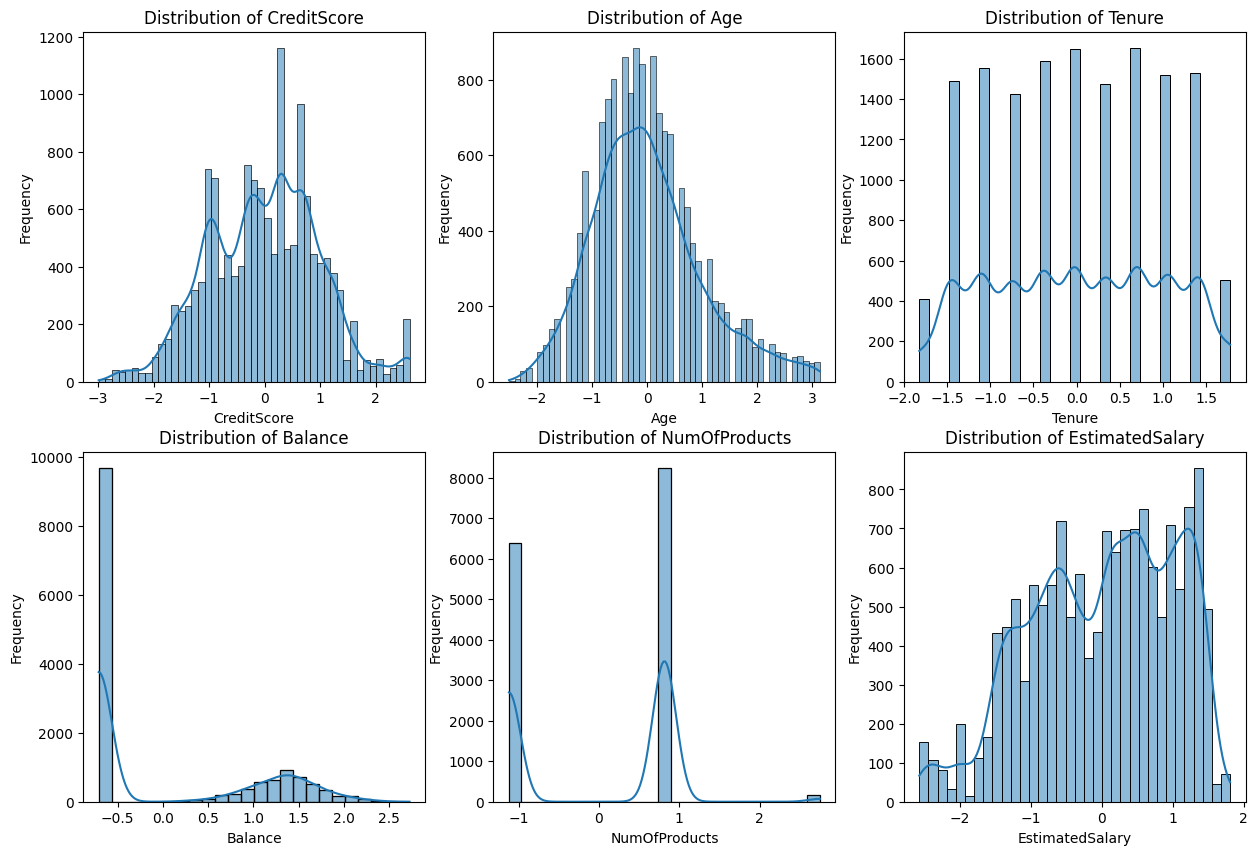

In [11]:
# Combined histogram plot for numeric columns after cleaning
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(ChurnData_Train_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.show()

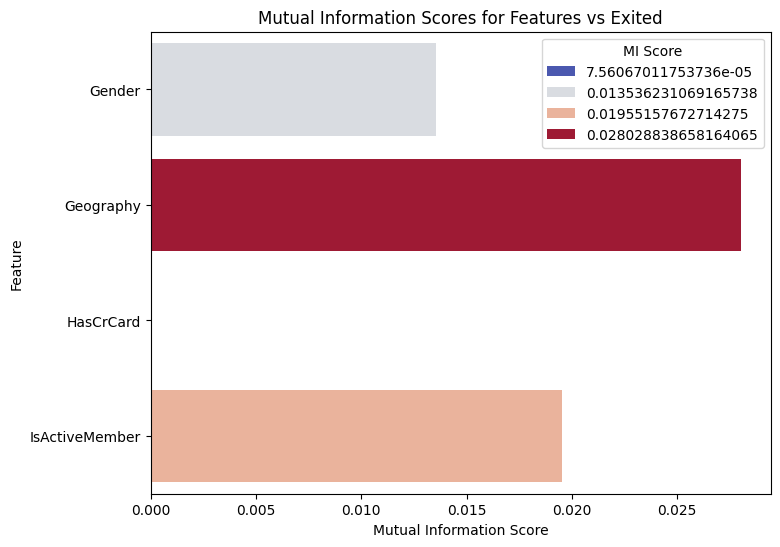

                MI Score
Feature                 
Geography       0.028029
IsActiveMember  0.019552
Gender          0.013536
HasCrCard       0.000076


In [12]:

from sklearn.metrics import mutual_info_score

# Specify the columns to analyze
columns_for_correlation = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'Exited']

# Select relevant columns from the cleaned DataFrame
correlation_data = ChurnData_Train_cleaned[columns_for_correlation]

# Calculate mutual information for each column against 'Exited'
mi_scores = []
for column in correlation_data.drop(columns='Exited').columns:
    mi = mutual_info_score(correlation_data[column], correlation_data['Exited'])
    mi_scores.append((column, mi))

# Convert results to a DataFrame for better visualization
mi_scores_df = pd.DataFrame(mi_scores, columns=['Feature', 'MI Score']).set_index('Feature')

# Plot the mutual information scores
plt.figure(figsize=(8, 6))
sns.barplot(x=mi_scores_df['MI Score'], y=mi_scores_df.index, hue=mi_scores_df['MI Score'] , palette='coolwarm')
plt.title('Mutual Information Scores for Features vs Exited')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()

# Display MI Scores sorted by their values
print(mi_scores_df.sort_values(by='MI Score', ascending=False))


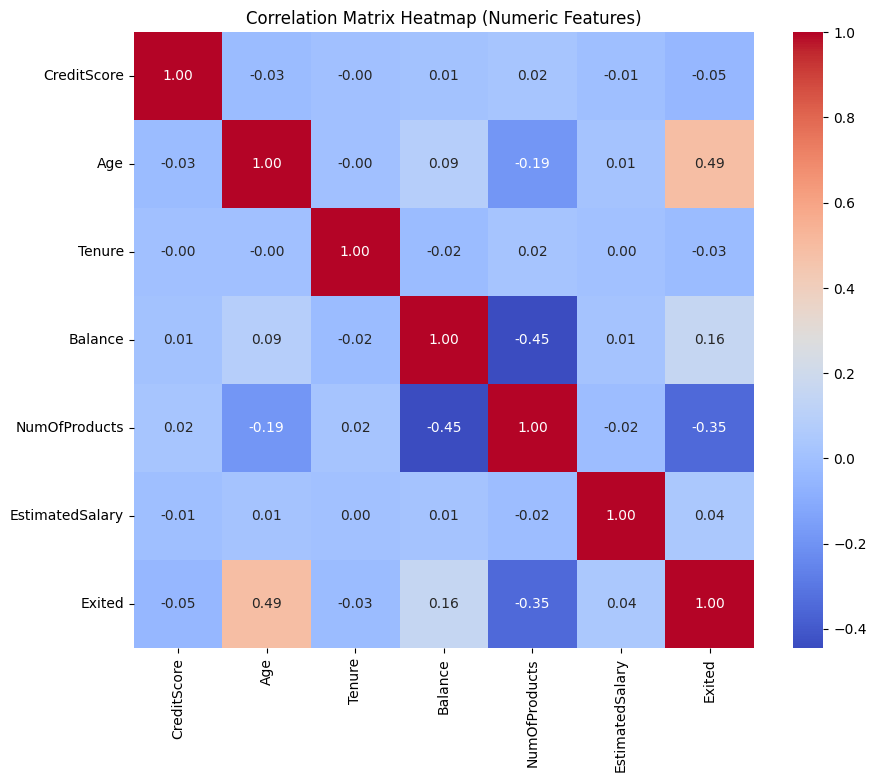

Age                0.132340
NumOfProducts      0.116411
Balance            0.018006
CreditScore        0.009992
Tenure             0.008767
EstimatedSalary    0.003630
Name: MI Scores, dtype: float64


In [13]:
from sklearn.feature_selection import mutual_info_classif

# Select numeric columns for correlation analysis
numeric_cols_for_correlation = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','Exited']
numeric_correlation_data = ChurnData_Train_cleaned[numeric_cols_for_correlation]

# Calculate mutual information for classification
mi_scores_numeric = mutual_info_classif(numeric_correlation_data.drop(columns='Exited'), numeric_correlation_data['Exited'])
mi_scores_numeric = pd.Series(mi_scores_numeric, name="MI Scores", index=numeric_correlation_data.drop(columns='Exited').columns)

# Create a correlation matrix heatmap for numeric features
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_correlation_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap (Numeric Features)')
plt.show()

# Display MI Scores for numeric features
print(mi_scores_numeric.sort_values(ascending=False))


# Model 1: Logistic Regression


Parameters to test:
*   penalty term (l1,l2,elastic net)
*   class_weight: try different weights depending on correlation to exited
* solver: Algorithm to use in the optimization problem
* max iterations


### Without Using Class Weight

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optim

Best hyperparameters: {'max_iter': 100, 'solver': 'newton-cg'}
Best accuracy score: 0.8826067143996363


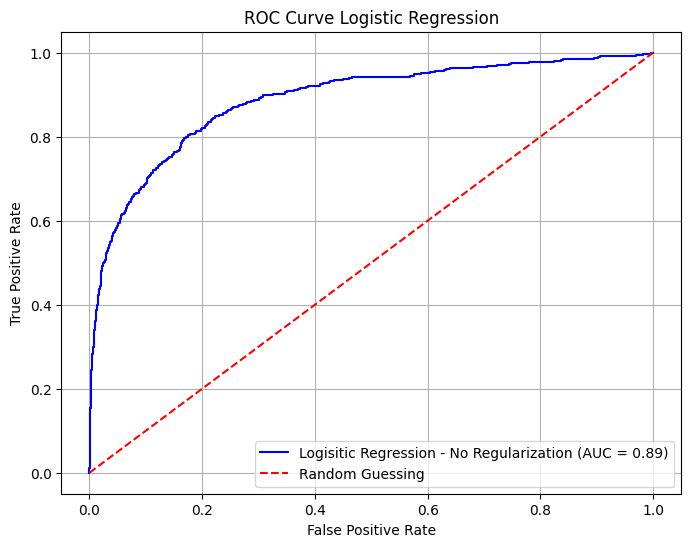

ROC AUC Score: 0.8869


In [29]:
# Without regularization : Base Model
# We will find the best number of iterations and which solver to use for the rest so we don't keep trying


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

#Validation Data
X = ChurnData_Train_cleaned_encoded.drop('Exited', axis=1)
y = ChurnData_Train_cleaned_encoded['Exited']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the parameter grid for GridSearchCV
param_grid = {
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Create a logistic regression model with no penalty
logreg = LogisticRegression(penalty=None)


# Create GridSearchCV object
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

# Evaluate the model with the best hyperparameters on the test set
best_logreg = grid_search.best_estimator_
y_logreg = best_logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_logreg)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logisitic Regression - No Regularization (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


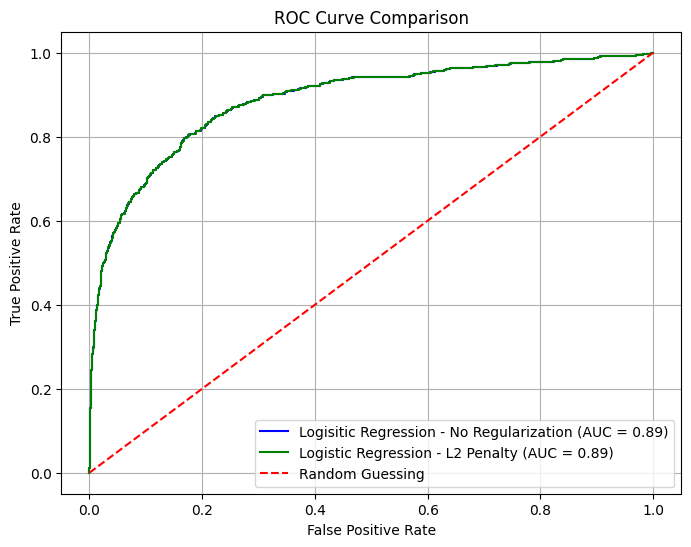

ROC AUC Score (Logistic Regression -L2 Regularization): 0.8869


In [15]:
# With Regularization
# From Base Model we got best number of iterations = 100, and best solver is newton-cg which uses L2 Regularization

# Validation Data Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a logistic regression model with L2 penalty, newton-cg solver, and max_iter=100
logreg_l2 = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=100)

# Fit the model to the training data
logreg_l2.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob_l2 = logreg_l2.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the L2 regularized model
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(y_test, y_pred_prob_l2)
roc_auc_l2 = auc(fpr_l2, tpr_l2)


# Plot the ROC curve for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logisitic Regression - No Regularization (AUC = {roc_auc:.2f})', color='blue')
plt.plot(fpr_l2, tpr_l2, label=f'Logistic Regression - L2 Penalty (AUC = {roc_auc_l2:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"ROC AUC Score (Logistic Regression -L2 Regularization): {roc_auc_l2:.4f}")

### Using Class Weight

In [16]:
#Generating Weights:
# Combine mi_scores_numeric and mi_scores_df
combined_mi_scores = pd.concat([mi_scores_numeric, mi_scores_df['MI Score']])
# Create a DataFrame for the combined scores
combined_mi_scores_df = pd.DataFrame({'Feature': combined_mi_scores.index, 'MI Score': combined_mi_scores.values})
class_weights = {0: 1, 1: 1}  # Initialize class weights

# Calculate class weights based on MI scores
for feature, mi_score in combined_mi_scores_df.set_index('Feature')['MI Score'].to_dict().items():
    if feature in X_train.columns:  # Check if the feature is in your training data
        class_weights[0] *= (1 - mi_score)  # Adjust weight for class 0
        class_weights[1] *= mi_score      # Adjust weight for class 1

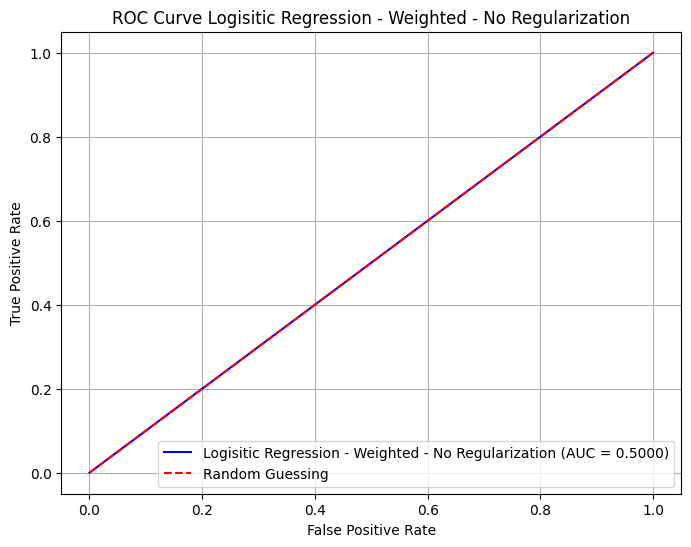

ROC AUC Score (Logisitic Regression - Weighted - No Regularization ): 0.5000


In [17]:
# Without Regularization
logreg_weight = LogisticRegression(penalty=None, class_weight=class_weights,  solver='newton-cg', max_iter=100)
# Fit the model to the training data
logreg_weight.fit(X_train, y_train)
# Make predictions on the test set
y_pred_prob_weight = logreg_weight.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the L2 regularized model
fpr_weight, tpr_weight, thresholds_weight = roc_curve(y_test, y_pred_prob_weight)
roc_auc_weight = auc(fpr_weight, tpr_weight)

# Plot the ROC curve for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr_weight, tpr_weight, label=f'Logisitic Regression - Weighted - No Regularization (AUC = {roc_auc_weight:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logisitic Regression - Weighted - No Regularization')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"ROC AUC Score (Logisitic Regression - Weighted - No Regularization ): {roc_auc_weight:.4f}")

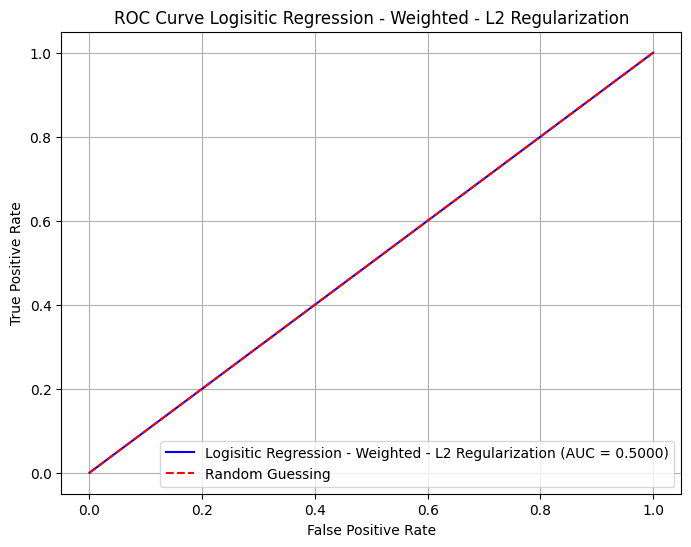

ROC AUC Score (Logisitic Regression - Weighted - L2 Regularization ): 0.5000


In [18]:
# With Regularization: Values will be based off the best ones we got in our base Model
logreg_weight_l2 = LogisticRegression(penalty='l2', class_weight=class_weights,  solver='newton-cg', max_iter=100)
# Fit the model to the training data
logreg_weight_l2.fit(X_train, y_train)
# Make predictions on the test set
y_pred_prob_weight_l2 = logreg_weight.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the L2 regularized model
fpr_weight_l2, tpr_weight_l2, thresholds_weight_l2 = roc_curve(y_test, y_pred_prob_weight_l2)
roc_auc_weight_l2 = auc(fpr_weight_l2, tpr_weight_l2)

# Plot the ROC curve for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr_weight, tpr_weight, label=f'Logisitic Regression - Weighted - L2 Regularization (AUC = {roc_auc_weight_l2:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logisitic Regression - Weighted - L2 Regularization')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"ROC AUC Score (Logisitic Regression - Weighted - L2 Regularization ): {roc_auc_weight_l2:.4f}")

# Model 2: Decision Trees
Parameters to test:


*   criterion : “gini”, “entropy”, “log_loss” - default=”gini”

  The function to measure the quality of a split. Supported criteria are “gini”
for the Gini impurity and “log_loss” and “entropy”.

* splitter: “best”, “random” - default=”best”

  The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.



### Using Gini

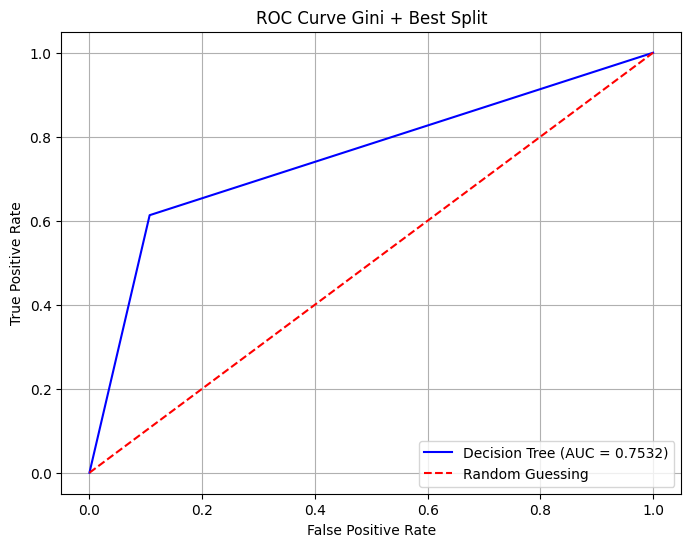

ROC AUC Score: 0.7532


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define features (X) and target (y)
X = ChurnData_Train_cleaned_encoded.drop(columns=['Exited', 'CustomerId'])  # Drop target and non-predictive columns
y = ChurnData_Train_cleaned_encoded['Exited']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree with Gini impurity and Best Split
clf_best = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)

# Train the model
clf_best.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba_best = clf_best.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Gini + Best Split')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


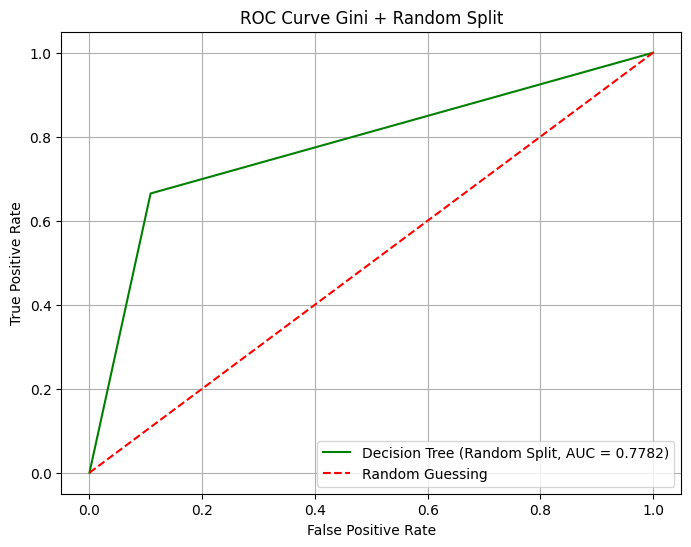

ROC AUC Score (Random Split): 0.7782


In [20]:
# Decision Tree with Gini impurity and Random Split
clf_random = DecisionTreeClassifier(criterion='gini', splitter='random', random_state=42)

# Train the model
clf_random.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba_random = clf_random.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute ROC curve and AUC
fpr_random, tpr_random, thresholds_random = roc_curve(y_test, y_pred_proba_random)
roc_auc_random = auc(fpr_random, tpr_random)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_random, tpr_random, label=f'Decision Tree (Random Split, AUC = {roc_auc_random:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Gini + Random Split')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"ROC AUC Score (Random Split): {roc_auc_random:.4f}")


### Using Entropy

Decision Tree with Entropy and Best Split:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      2397
         1.0       0.60      0.63      0.62       561

    accuracy                           0.85      2958
   macro avg       0.76      0.77      0.76      2958
weighted avg       0.85      0.85      0.85      2958

ROC-AUC Score: 0.7667538969166003


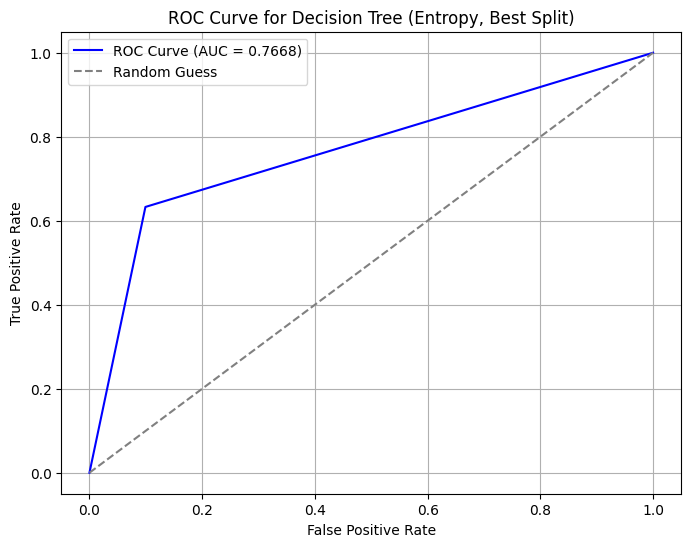

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# 1. Decision Tree with Entropy and Best Split
clf_best_entropy = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=42)

# Train the model
clf_best_entropy.fit(X_train, y_train)

# Make predictions
y_pred_best_entropy = clf_best_entropy.predict(X_test)

# Predict probabilities for ROC curve
y_pred_proba_best_entropy = clf_best_entropy.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Decision Tree with Entropy and Best Split:")
print("Classification Report:")
print(classification_report(y_test, y_pred_best_entropy))

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba_best_entropy)
print(f"ROC-AUC Score: {roc_auc}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best_entropy)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("ROC Curve for Decision Tree (Entropy, Best Split)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()



Decision Tree with Entropy and Random Split:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      2397
         1.0       0.59      0.63      0.61       561

    accuracy                           0.85      2958
   macro avg       0.75      0.77      0.76      2958
weighted avg       0.85      0.85      0.85      2958

ROC-AUC Score: 0.7650282550157392


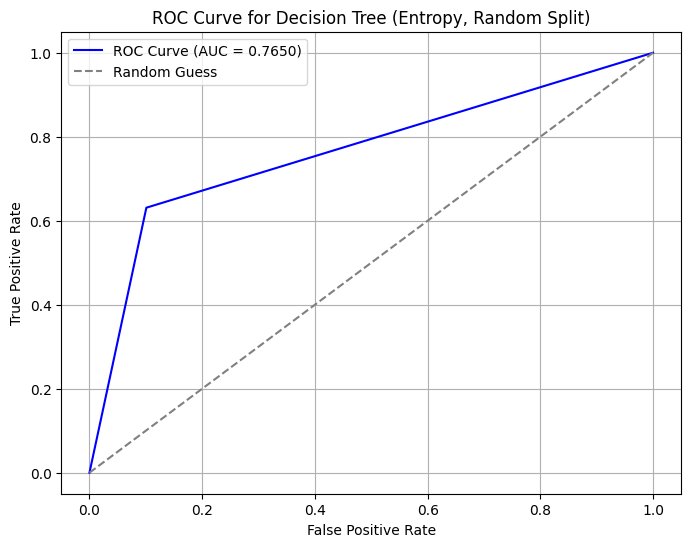

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# 1. Decision Tree with Entropy and Random Split
clf_random_entropy = DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=42)

# Train the model
clf_random_entropy.fit(X_train, y_train)

# Make predictions
y_pred_random_entropy = clf_random_entropy.predict(X_test)

# Predict probabilities for ROC curve
y_pred_proba_random_entropy = clf_random_entropy.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nDecision Tree with Entropy and Random Split:")
print("Classification Report:")
print(classification_report(y_test, y_pred_random_entropy))

# Calculate the ROC-AUC score
roc_auc_random = roc_auc_score(y_test, y_pred_proba_random_entropy)
print(f"ROC-AUC Score: {roc_auc_random}")

# Plot the ROC curve
fpr_random, tpr_random, thresholds_random = roc_curve(y_test, y_pred_proba_random_entropy)
plt.figure(figsize=(8, 6))
plt.plot(fpr_random, tpr_random, color='blue', label=f"ROC Curve (AUC = {roc_auc_random:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("ROC Curve for Decision Tree (Entropy, Random Split)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


# Model 3: Random Forests

Parameters to test:
* n_estimators: number of trees used , default = 100
* criterion:{“gini”, “entropy”, “log_loss”}, default=”gini”
* bootstrap: use random sampling of data in trees (True or False)
* oob_score: If using Bootstrapping we can use OOB scores to see which trees are preforming well (True or False)

### Without Bootstrapping

n_estimators=64, AUC=0.9176930908139035
n_estimators=72, AUC=0.9177168876425301
n_estimators=80, AUC=0.9184980929072808
n_estimators=88, AUC=0.9193201989712334
n_estimators=96, AUC=0.9202043998848828
n_estimators=104, AUC=0.9207848194080985
n_estimators=112, AUC=0.9206639761377302
n_estimators=120, AUC=0.920954743637509

Best n_estimators: 120, Best AUC: 0.920954743637509


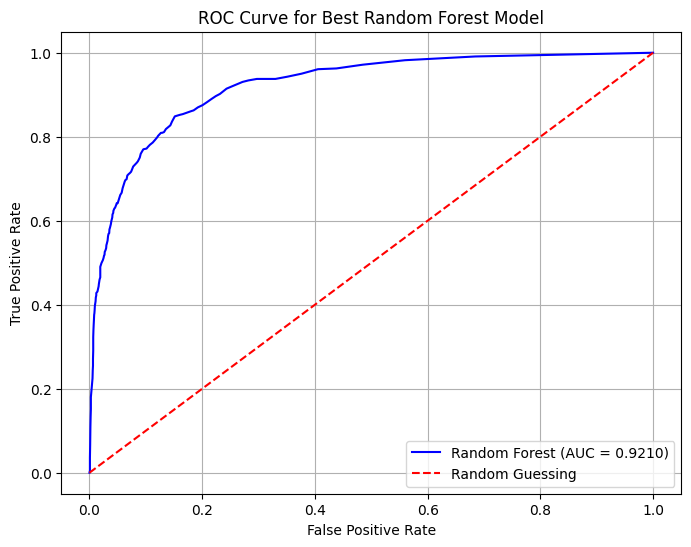

In [31]:
# We'll Use the criterion that got the best score in the Decision Trees Model - gini - random
from sklearn.ensemble import RandomForestClassifier

# Define features (X) and target (y)
X = ChurnData_Train_cleaned_encoded.drop(columns=['Exited', 'CustomerId'])
y = ChurnData_Train_cleaned_encoded['Exited']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_roc_auc = 0
best_n_estimators = 0

for n_estimators in range(64, 125, 8):
    # Initialize RandomForestClassifier with bootstrap=False
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', bootstrap=False, random_state=42)

    # Train the model
    rf_classifier.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
    roc_auc = auc(fpr, tpr)

    print(f"n_estimators={n_estimators}, AUC={roc_auc}")

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_n_estimators = n_estimators

print(f"\nBest n_estimators: {best_n_estimators}, Best AUC: {best_roc_auc}")

# Train the model with the best n_estimators
best_rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', bootstrap=False, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Predict probabilities for the best model
y_pred_proba_best = best_rf_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)


# Plot the ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f'Random Forest (AUC = {roc_auc_best:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### With Bootstrapping

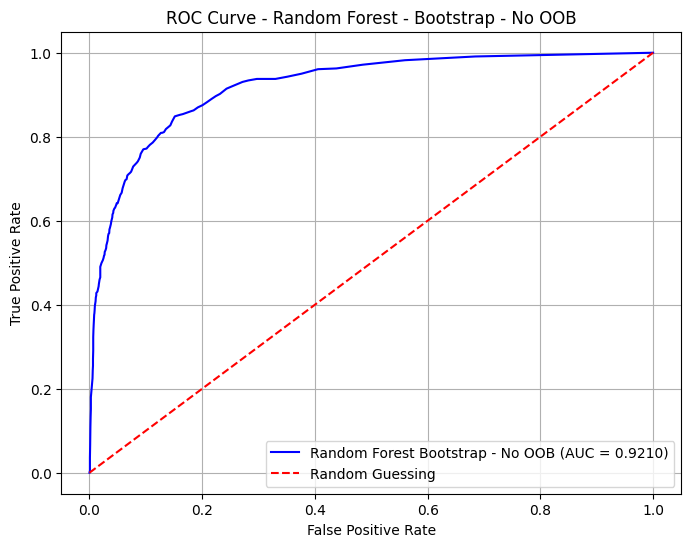

In [24]:
# Without OOB Score
rf_classifier_boostrap = RandomForestClassifier(n_estimators=120, criterion='gini', bootstrap=True, random_state=42, oob_score=False)
rf_classifier_boostrap.fit(X_train, y_train)

# Predict probabilities for the best model
y_pred_proba_bootstrap = rf_classifier_boostrap.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the best model
fpr_bootstrap, tpr_bootstrap, thresholds_bootstrap= roc_curve(y_test, y_pred_proba_best)
roc_auc_bootstrap = auc(fpr_bootstrap, tpr_bootstrap)


# Plot the ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr_bootstrap, tpr_bootstrap, label=f'Random Forest Bootstrap - No OOB (AUC = {roc_auc_bootstrap:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest - Bootstrap - No OOB')
plt.legend(loc='lower right')
plt.grid()
plt.show()

OOB Score: 0.8936


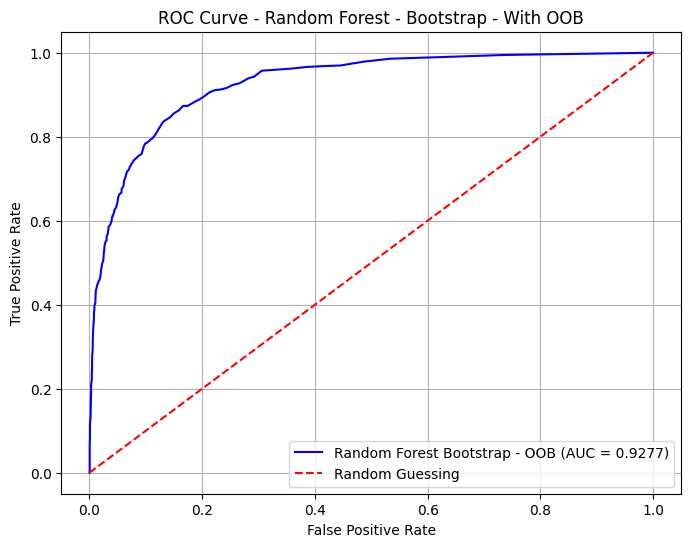

In [25]:
# With OOB Score
rf_classifier_boostrap_OOB= RandomForestClassifier(n_estimators=120, criterion='gini', bootstrap=True, random_state=42, oob_score=True)
rf_classifier_boostrap_OOB.fit(X_train, y_train)

# Display the OOB score
print(f"OOB Score: {rf_classifier_boostrap_OOB.oob_score_:.4f}")

# Predict probabilities for the best model
y_pred_proba_bootstrap_OOB = rf_classifier_boostrap_OOB.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the best model
fpr_bootstrap_OOB, tpr_bootstrap_OOB, thresholds_bootstrap_OOB = roc_curve(y_test, y_pred_proba_bootstrap_OOB)
roc_auc_bootstrap_OOB = auc(fpr_bootstrap_OOB, tpr_bootstrap_OOB)

# Plot the ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr_bootstrap_OOB, tpr_bootstrap_OOB, label=f'Random Forest Bootstrap - OOB (AUC = {roc_auc_bootstrap_OOB:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest - Bootstrap - With OOB')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model Evaluation
Seeing Which Models worked Best

<Figure size 1600x800 with 0 Axes>

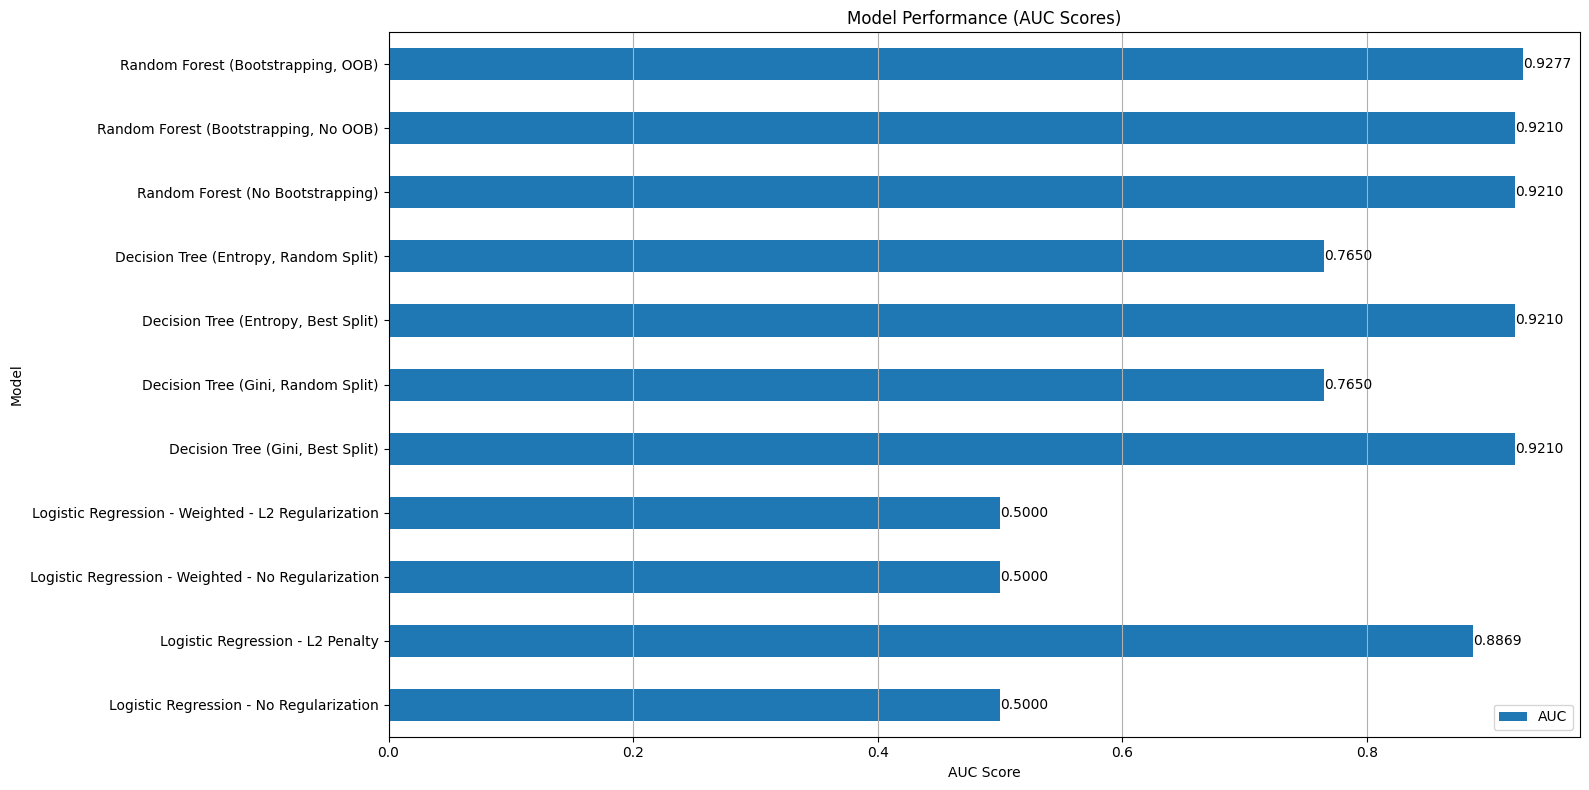

In [26]:
auc_scores = {
    'Model': ['Logistic Regression - No Regularization', 'Logistic Regression - L2 Penalty',
              'Logistic Regression - Weighted - No Regularization', 'Logistic Regression - Weighted - L2 Regularization',
              'Decision Tree (Gini, Best Split)', 'Decision Tree (Gini, Random Split)',
              'Decision Tree (Entropy, Best Split)', 'Decision Tree (Entropy, Random Split)',
              'Random Forest (No Bootstrapping)', 'Random Forest (Bootstrapping, No OOB)',
              'Random Forest (Bootstrapping, OOB)'],
    'AUC': [roc_auc_weight, roc_auc_l2, roc_auc_weight, roc_auc_weight_l2,
                       roc_auc, roc_auc_random, roc_auc, roc_auc_random,
                       roc_auc_best, roc_auc_bootstrap, roc_auc_bootstrap_OOB]
}

# Create a DataFrame from the dictionary
auc_df = pd.DataFrame(auc_scores)

# Set 'Model' as the index
auc_df = auc_df.set_index('Model')


# Create a bar chart to compare validation and test AUC scores
plt.figure(figsize=(16, 8))
bars = auc_df.plot(kind='barh', figsize=(16, 8))  # Store the bar plot object
plt.title('Model Performance (AUC Scores)')
plt.ylabel('Model')
plt.xlabel('AUC Score')
plt.grid(axis='x')

# Annotate each bar
for bar in bars.patches:
    # Get the width (AUC value) and height (model index) of the bar
    width = bar.get_width()
    height = bar.get_y() + bar.get_height() / 2

    # Get the corresponding model name from the index
    model_name = auc_df.index[bars.patches.index(bar)]

    # Format the AUC value to 4 significant figures
    auc_text = f'{width:.4f}'

    # Annotate the bar
    plt.annotate(auc_text, (width, height), ha='left', va='center')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

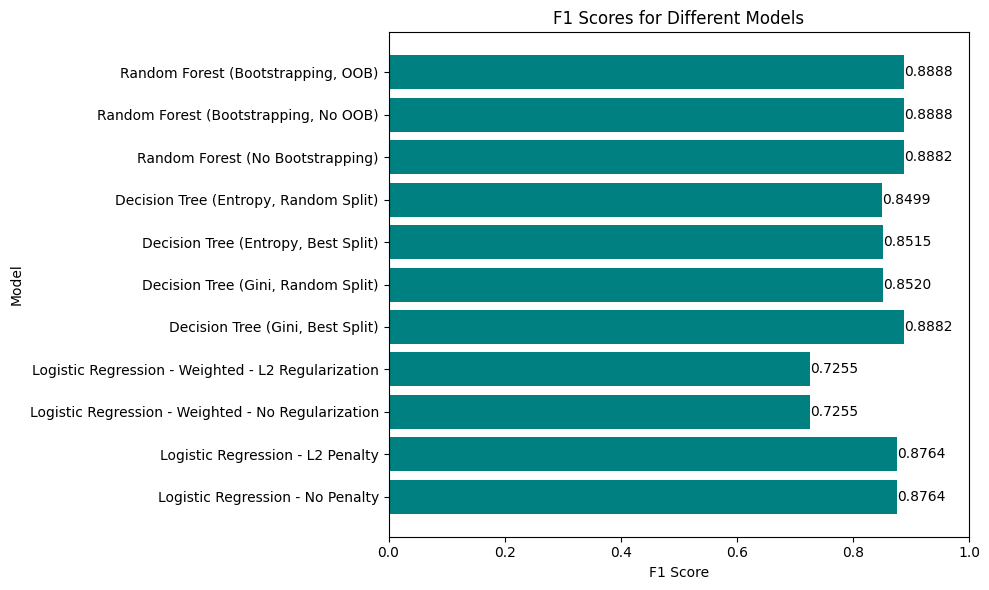

In [34]:
from sklearn.metrics import f1_score

# Calculate f1 scores
f1_scores = []
model_names = []


model_names.append("Logistic Regression - No Penalty")
f1_scores.append(f1_score(y_test, np.round(y_logreg), average='weighted'))

model_names.append("Logistic Regression - L2 Penalty")
f1_scores.append(f1_score(y_test, np.round(y_pred_prob_l2), average='weighted'))

model_names.append("Logistic Regression - Weighted - No Regularization")
f1_scores.append(f1_score(y_test, np.round(y_pred_prob_weight), average='weighted'))


model_names.append("Logistic Regression - Weighted - L2 Regularization")
f1_scores.append(f1_score(y_test, np.round(y_pred_prob_weight_l2), average='weighted'))

model_names.append('Decision Tree (Gini, Best Split)')
f1_scores.append(f1_score(y_test, np.round(y_pred_proba_best), average='weighted'))

model_names.append('Decision Tree (Gini, Random Split)')
f1_scores.append(f1_score(y_test, np.round(y_pred_proba_random), average='weighted'))

model_names.append('Decision Tree (Entropy, Best Split)')
f1_scores.append(f1_score(y_test, np.round(y_pred_proba_best_entropy), average='weighted'))

model_names.append('Decision Tree (Entropy, Random Split)')
f1_scores.append(f1_score(y_test, np.round(y_pred_proba_random_entropy), average='weighted'))

model_names.append('Random Forest (No Bootstrapping)')
f1_scores.append(f1_score(y_test, np.round(y_pred_proba_rf), average='weighted'))

model_names.append('Random Forest (Bootstrapping, No OOB)')
f1_scores.append(f1_score(y_test, np.round(y_pred_proba_bootstrap), average='weighted'))

model_names.append('Random Forest (Bootstrapping, OOB)')
f1_scores.append(f1_score(y_test, np.round(y_pred_proba_bootstrap_OOB), average='weighted'))



# Create the horizontal bar graph
plt.figure(figsize=(10, 6))
plt.barh(model_names, f1_scores, color='teal')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.title('F1 Scores for Different Models')
plt.xlim(0, 1) # Set x-axis limit to 0-1 for F1 scores

# Add value labels to each bar
for index, value in enumerate(f1_scores):
    plt.text(value, index, f"{value:.4f}", va='center')

plt.tight_layout()
plt.show()

# Kaggle Submissions

In [35]:
# Set up Test Data:
ChurnData_Test_cleaned = ChurnData_Test.copy()
ChurnData_Test_cleaned[numeric_columns] = scaler.fit_transform(ChurnData_Test_cleaned[numeric_columns].values)
ChurnData_Test_cleaned_encoded = pd.get_dummies(ChurnData_Test_cleaned, columns=categorical_cols, drop_first=False)
ChurnData_Test_cleaned_encoded = pd.get_dummies(ChurnData_Test_cleaned_encoded, columns=['Geography'], drop_first=True)
ChurnData_Test_cleaned_encoded.drop(columns=['Surname'], inplace=True)
ChurnData_Test_cleaned_encoded.drop(columns=['id'], inplace=True)
ChurnData_Test_cleaned_encoded.drop(columns=['CustomerId'], inplace=True)

ChurnData_Test_cleaned_encoded

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Gender_Female,Gender_Male,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0,Geography_Germany,Geography_Spain
0,1.407524,-0.101467,-0.017947,-0.712814,-1.129947,-0.590273,False,True,False,True,True,False,False,True
1,-0.162396,-1.204634,-0.017947,1.322848,0.759280,-0.874454,False,True,True,False,True,False,True,False
2,1.159642,-0.714337,0.698517,1.603125,-1.129947,0.286396,False,True,False,True,False,True,False,False
3,1.490151,0.879126,0.340285,-0.712814,-1.129947,0.416699,True,False,False,True,False,True,False,True
4,0.856675,0.143681,-1.092644,0.776584,0.759280,0.629251,False,True,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.787400,2.472589,-0.017947,-0.712814,0.759280,0.112916,False,True,True,False,True,False,False,False
9996,0.939302,-0.836911,1.773214,-0.712814,0.759280,-1.061595,False,True,True,False,True,False,False,False
9997,1.021930,-0.714337,-1.450876,1.156799,-1.129947,-0.438605,True,False,False,True,True,False,True,False
9998,-1.319179,-0.346615,0.698517,-0.712814,0.759280,0.428917,True,False,False,True,False,True,False,False


In [36]:
# Predict on the test data
y_pred_test = rf_classifier_boostrap_OOB.predict(ChurnData_Test_cleaned_encoded)
submission_df = pd.DataFrame({'id': ChurnData_Test['id'], 'Exited': y_pred_test})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

# Download the file
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>